Found 6500 files belonging to 4 classes.
Found 724 files belonging to 4 classes.


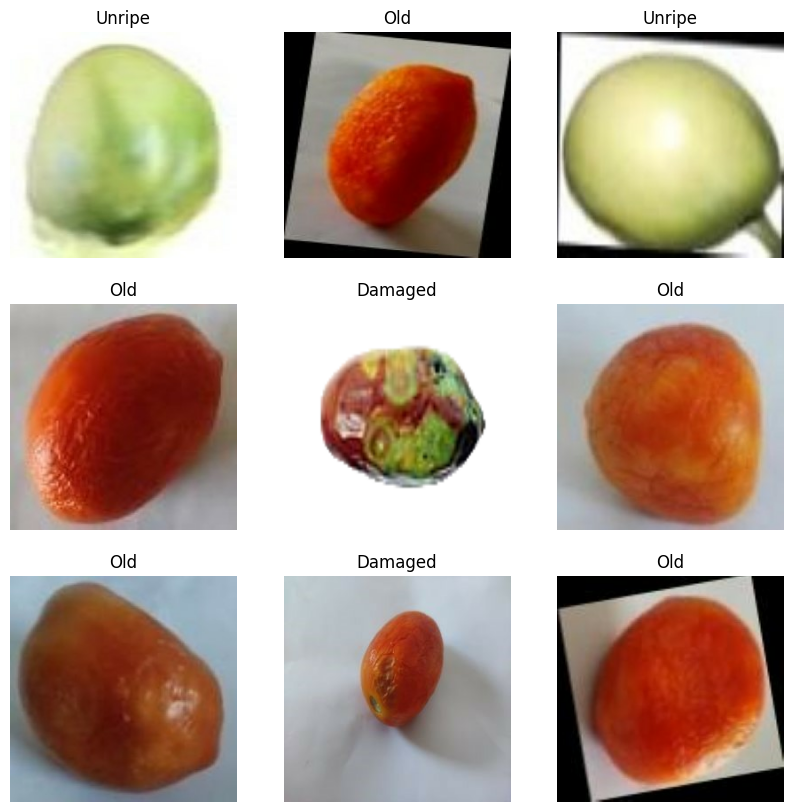

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt


# Load dataset
train_dir = 'content/ieee-mbl-cls/train'
validation_dir = 'content/ieee-mbl-cls/val'

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
# Creating test set 
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# Performance configurations
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Number of validation batches: 19
Number of test batches: 4


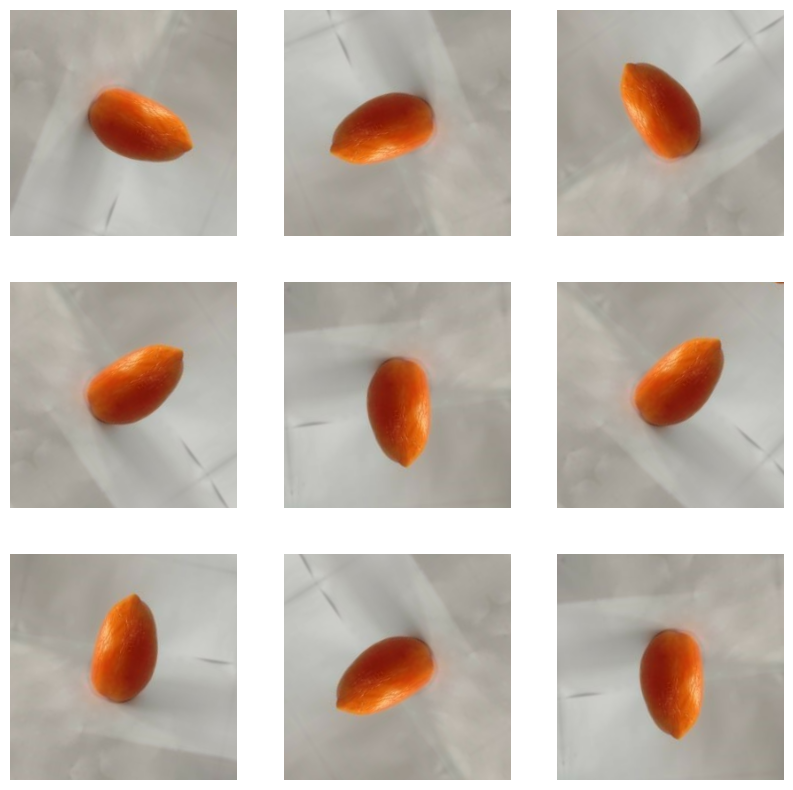

In [38]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [39]:
# Load and set up base model
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras import layers, models, optimizers

# Load with pre-trained weights
base_model = efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

# Build full model
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)  # 4-class output

model = models.Model(inputs, outputs)

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,796 (23.21 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.2772 - loss: 1.3423
initial loss: 1.33
initial accuracy: 0.30
Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 70s 320ms/step - accuracy: 0.6226 - loss: 0.9542 - val_accuracy: 0.8859 - val_loss: 0.3827
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 64s 316ms/step - accuracy: 0.8709 - loss: 0.3789 - val_accuracy: 0.9060 - val_loss: 0.2691
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 66s 321ms/step - accuracy: 0.8952 - loss: 0.2946 - val_accuracy: 0.9178 - val_loss: 0.2300
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 332ms/step - accuracy: 0.9006 - loss: 0.2658 - val_accuracy: 0.9144 - val_loss: 0.2169
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 64s 313ms/step - accuracy: 0.9139 - loss: 0.2323 - val_accuracy: 0.9262 - val_loss: 0.1955
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 65s 317ms/step - accuracy: 0.9197 - loss: 0.2212 - val_accuracy: 0.9329 - val_loss: 0.1780
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 64s 316ms/step - accuracy: 0.9297 - loss: 0.1956 - val_ac

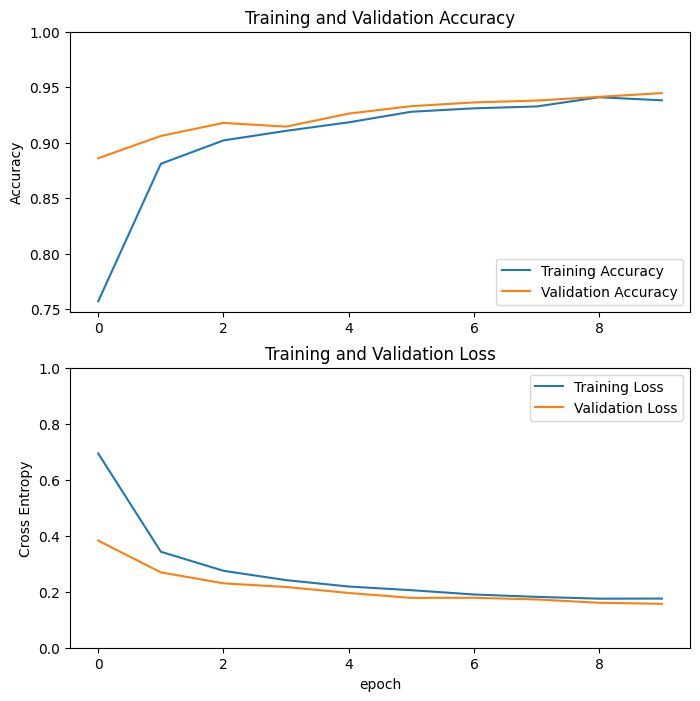

In [40]:
# Compile and train
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs  # Start with 10, increase if needed
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

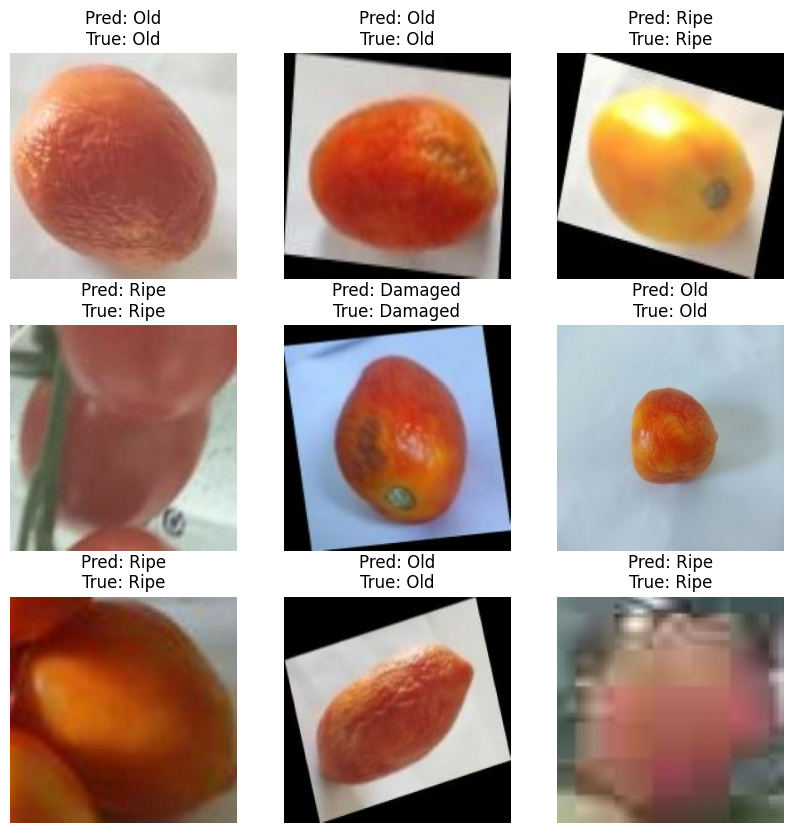

In [41]:
# Test validation

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# Predict on batch
pred_probs = model.predict_on_batch(image_batch)  # shape: (batch_size, 4)
pred_class_indices = tf.argmax(pred_probs, axis=1).numpy()  # get most probable class

# Display predictions vs ground truth
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    pred_label = class_names[pred_class_indices[i]]
    true_label = class_names[label_batch[i]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")
